In [ ]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [49]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/data/stage1_train/000711...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,27.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
1,003cee89357d9fe13516167fd67b609a164651b2193458...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/data/stage1_train/003cee...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,36.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/data/stage1_train/00ae65...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,70.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/data/stage1_train/0121d6...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,86.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/data/stage1_train/01d44a...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,320,256,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed_...,/mnt/ml-team/dsb_2018/files/contours_overlayed...


In [180]:
import numpy as np
from itertools import product


def random_colors(img, max_colours=1000):
    keys = list(range(1, 1000,1))
    np.random.shuffle(keys)
    values = list(range(1, 1000,1))
    np.random.shuffle(values)
    funky_dict = {k:v for k,v in zip(keys, values)}
    funky_dict[0] = 0

    h,w = img.shape
    
    for i,j in product(range(h),range(w)):
        img[i,j] = funky_dict[img[i,j]]
    return img

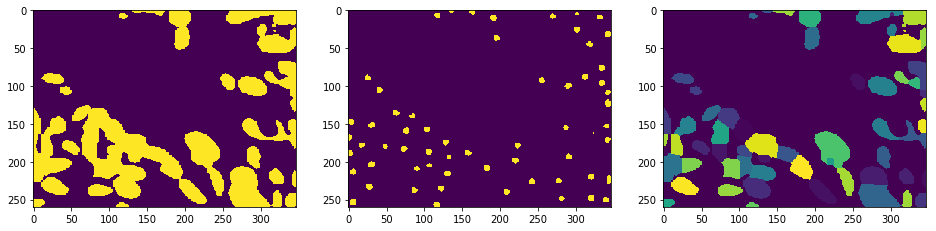

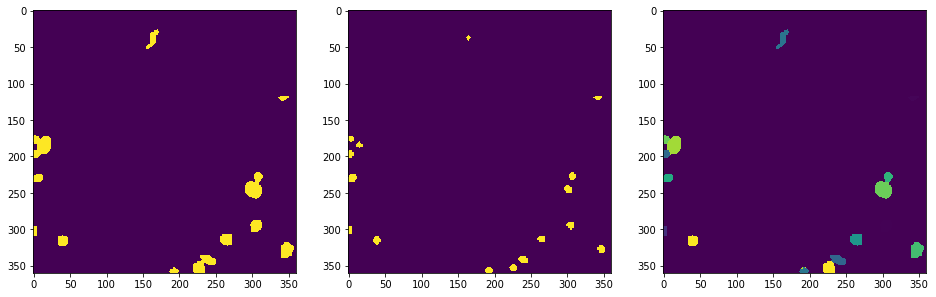

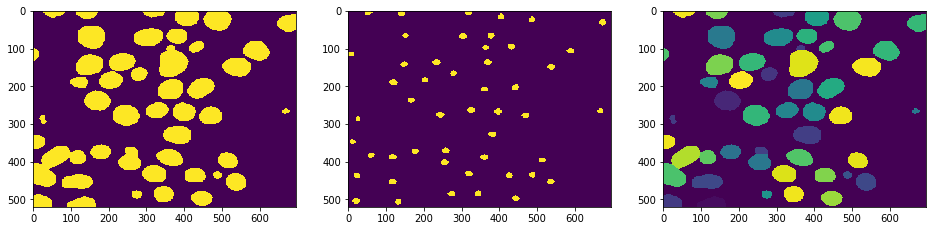

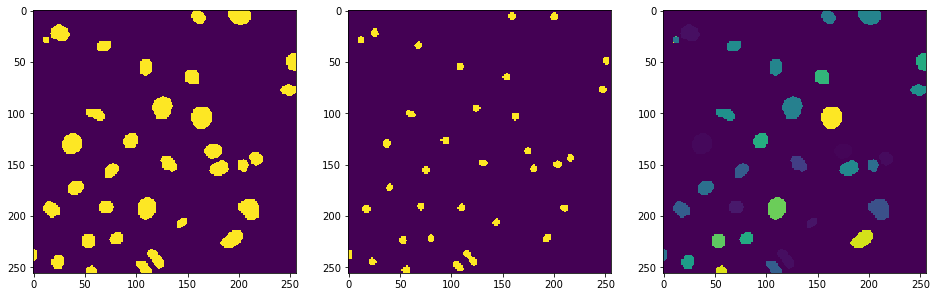

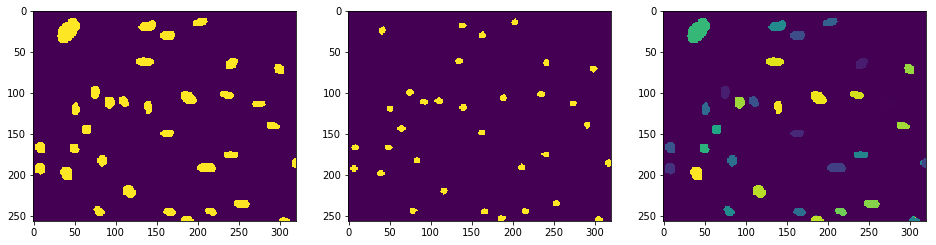

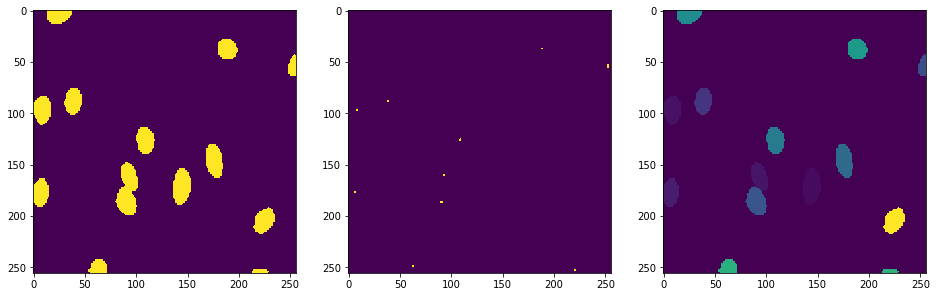

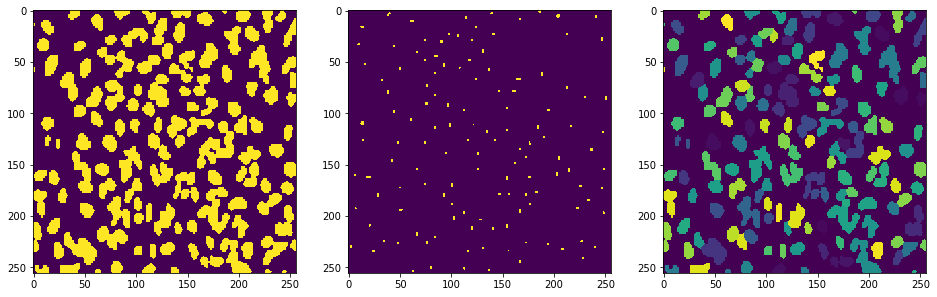

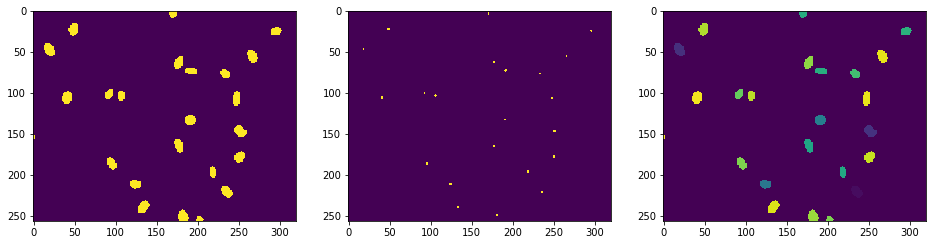

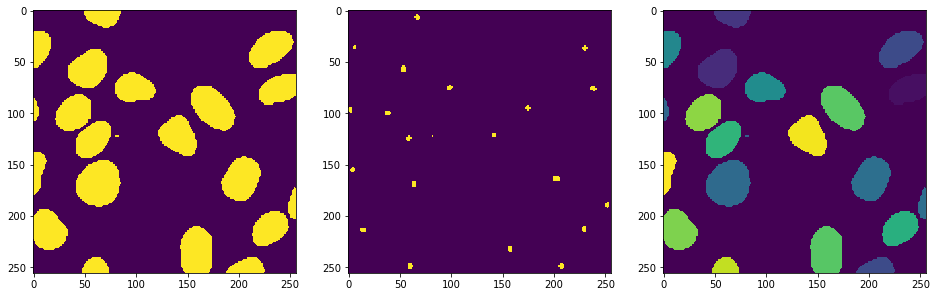

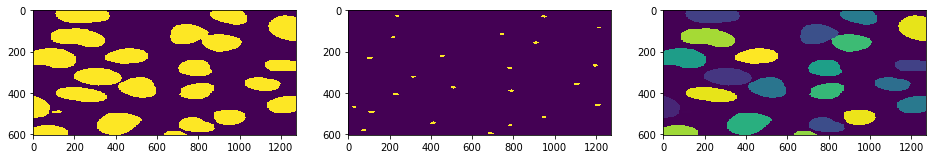

In [183]:
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_tripled_dev/outputs/mask_thresholding')

center_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_tripled_dev/outputs/center_thresholding')

watershed = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_tripled_dev/outputs/watershed')

for idx in range(10):
    m = mask_threshold['binarized_images'][idx]
    c = center_thresholding['binarized_images'][idx]
    w = watershed['detached_images'][idx]

    plt.figure(figsize=(16,12))
    plt.subplot(131)
    plt.imshow(m)
    plt.subplot(132)
    plt.imshow(c) 
    plt.subplot(133)
    plt.imshow(random_colors(w))      
    plt.show()


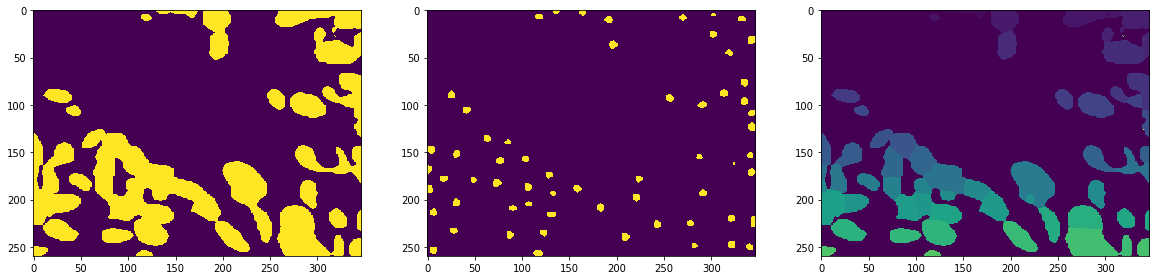

In [164]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
from scipy import ndimage as ndi
from sklearn.externals import joblib
from skimage.transform import resize
import skimage.morphology as morph

def detach_nuclei(image, center):
    distance = ndi.distance_transform_edt(image)   
    markers, nr_blobs = ndi.label(center)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)

    correct_labeled = dropped + labeled
    return correct_labeled

res = detach_nuclei(mask_threshold, center_thresholding)

plt.figure(figsize=(20,16))
plt.subplot(131)
plt.imshow(mask_threshold)
plt.subplot(132)
plt.imshow(center_thresholding) 
plt.subplot(133)
plt.imshow(res)      
plt.show()

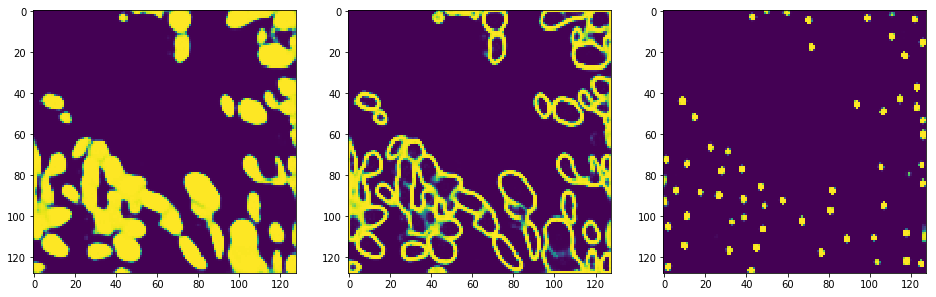

In [114]:
outputs = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_tripled_dev/outputs/unet_multitask')
plt.figure(figsize=(16,12))
for i,(name, output) in enumerate(outputs.items()):
    plt.subplot(1,3,i+1)
    plt.imshow(output[0])  
plt.show()

In [66]:
from scipy.stats import itemfreq
itemfreq(contour)

array([[  3.92156886e-03,   1.19107000e+05],
       [  1.25490203e-01,   1.03550000e+04],
       [  1.41176477e-01,   1.38000000e+02],
       [  2.66666681e-01,   1.19107000e+05],
       [  3.29411775e-01,   1.19107000e+05],
       [  5.49019635e-01,   1.03550000e+04],
       [  5.64705908e-01,   1.03550000e+04],
       [  9.05882359e-01,   1.38000000e+02],
       [  9.92156863e-01,   1.38000000e+02],
       [  1.00000000e+00,   1.29600000e+05]])